In [1]:
# Imports

import os
import random
import time

import cv2
import numpy as np
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as DisplayImage

In [2]:
number_of_frames = 2000 # Reduce the number of frames to lessen impact on memory
number_of_tvs = 10000 # Reduce the set of TVs so that it is digestable by UMAP

In [13]:
# Step 1. Grab a random assortment of frames from the movie

np.random.seed(1)

def random_frames_from_video(video_path, num_frames=5):
    """
    Extracts random frames from a video and returns them as a list of NumPy arrays.
    
    Parameters:
        video_path (str): Path to the video file.
        num_frames (int): Number of random frames to extract.
        
    Returns:
        list: NumPy array of NumPy arrays representing the frames.
    """
    # Open the video using OpenCV
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error: Couldn't open the video file.")
        return []

    frames = []

    for _ in tqdm(range(num_frames), desc="Loading in video frames"):
        # Get a random frame number
        frame_num = random.randint(0, total_frames - 1)
        # Set the video position to the frame number
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        # Read the frame
        ret, frame = cap.read()

        if ret:
            frames.append(frame)

    # Release the video capture object
    cap.release()

    # Convert frames to numpy array
    frames = np.array(frames)
    
    return frames

# Extract random frames from the video
frames = random_frames_from_video('cab_ride_trimmed.mkv', num_frames=number_of_frames)
width = frames.shape[1]
height = frames.shape[2]
random_indices = np.random.permutation(width * height) # for shuffling TVs later...

Loading in video frames: 100%|█████████████████████████████████████████████████████| 2000/2000 [03:21<00:00,  9.91it/s]


**TODO**: set this up so that instead of grabbing entire frames, we just grab the TVs so that way we can increase the number of frames we can use


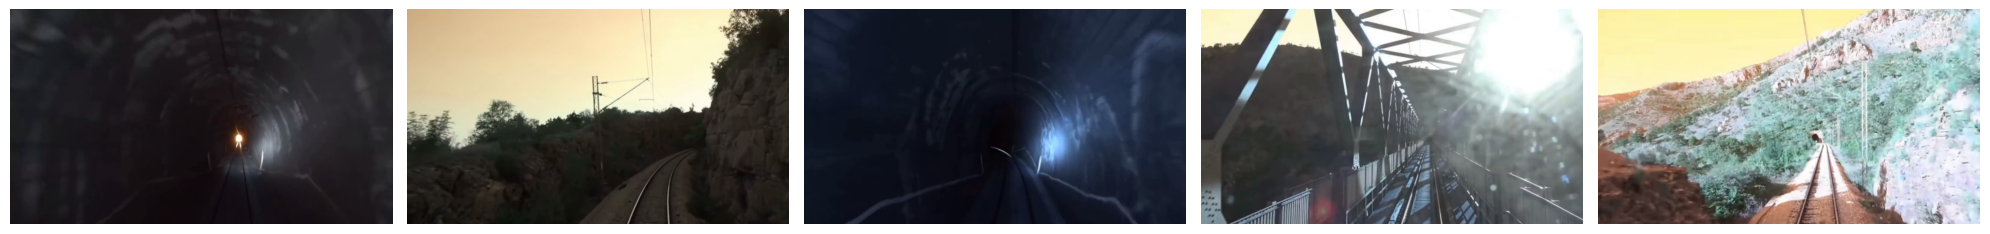

In [14]:
# Step 2: Preview a random sample of images

import matplotlib.pyplot as plt
def display_random_frames():
    # Display up to 5 frames
    display_frames = frames[:5]
    
    fig, axs = plt.subplots(1, len(display_frames), figsize=(20, 5))
    
    for ax, frame in zip(axs, display_frames):
        ax.imshow(frame)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

display_random_frames()

In [5]:
# Step 3: Split each pixel position into its respective color series
# (AKA: TVs)

def pixel_color_series(x_position, y_position):
    return frames[:, x_position, y_position]

def tv(position):
    # select a random position so that there aren't any clues about where the TV goes
    position = random_indices[position]

    # convert to an x, y position
    x_position = position % width
    y_position = position // width
    return frames[:, x_position, y_position]

tvs = []
for i in tqdm(range(number_of_tvs), desc="Flattening tvs and turning them into a list"):
    tvs.append(tv(i).flatten())

del frames # clear out the frames, because by using flatten() we have created a copy
# note: ravel() might work to return a view instead of making a copy, try this later...

Flattening tvs and turning them into a list: 100%|█████████████████████████████| 10000/10000 [00:02<00:00, 3561.35it/s]


At this point, we now have each TV stored in the list <b><i>tvs</i></b>.

We should now be applying UMAP to the TVs!

In [6]:
n_neighbors = 100

In [7]:
# Step 4: Run UMAP

# Initialize UMAP with desired parameters
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1, n_components=2, metric='euclidean', n_jobs = -1, verbose = True)

# Fit and transform the data
embedding = reducer.fit_transform(tvs[:number_of_tvs])
x_coordinates, y_coordinates = embedding[:, 0], embedding[:, 1]


UMAP(n_neighbors=100, verbose=True)
Mon Sep 30 12:41:32 2024 Construct fuzzy simplicial set
Mon Sep 30 12:41:33 2024 Finding Nearest Neighbors
Mon Sep 30 12:41:33 2024 Building RP forest with 10 trees
Mon Sep 30 12:41:39 2024 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Mon Sep 30 12:43:23 2024 Finished Nearest Neighbor Search
Mon Sep 30 12:43:27 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Sep 30 12:43:39 2024 Finished embedding


In [8]:
# Step 5. Convert the TVs back into a nice "list of colors" format
# instead of a plain old list of values

def list_to_colors(input_list):
    '''
    Parameters:
        input_list: some list of numbers, like [1, 2, 3, 4, 5, 6]

    Returns:
        color_list: the input list chunked in threes, i.e.: [[1, 2, 3], [4, 5, 6]]
    '''
    if len(input_list) % 3 != 0:
        raise ValueError("The length of the list must be a multiple of 3.")
    return [tuple(input_list[i:i + 3]) for i in range(0, len(input_list), 3)]

relevant_tvs = []
for tv in tqdm(tvs[:number_of_tvs], desc = "Converting lists back to colors"):
    relevant_tvs.append(list_to_colors(tv))



Converting lists back to colors: 100%|██████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.93it/s]


Loading animation: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.84it/s]


GIF created and saved as animation.gif


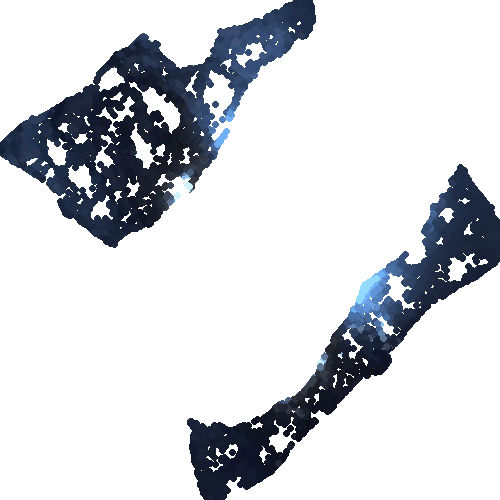

In [9]:
# Step 6. Create the animation

from PIL import Image, ImageDraw
import os
from tqdm import tqdm

def normalize_list(input_list):
    min_val = min(input_list)
    max_val = max(input_list)
    return [(x - min_val) / (max_val - min_val) for x in input_list]

def create_color_animation(color_list, x_list, y_list, output_filename='animation.gif', num_frames=None):
    # Set the image size and other parameters
    img_size = (500, 500)
    point_radius = 3  # Adjust point size as needed
    background_color = (255, 255, 255)  # White background
    x_list, y_list = normalize_list(x_list), normalize_list(y_list)
    
    if not num_frames:
        num_frames = len(color_list[0])  # Determine the number of frames from color_list
    
    images = []
    
    # Loop through each frame to generate images
    for frame in tqdm(range(num_frames), desc="Loading animation"):
        # Create a blank image with white background
        img = Image.new('RGB', img_size, background_color)
        draw = ImageDraw.Draw(img)
        
        # Draw each point for the current frame
        for i in range(len(x_list)):
            # Convert x, y to pixel coordinates (scaled to fit the image size)
            x = int(x_list[i] * (img_size[0]))  # Assuming x_list ranges from 0 to 1
            y = int(y_list[i] * (img_size[1]))  # Assuming y_list ranges from 0 to 1
            
            # Get the color for the current frame
            color = tuple(map(int, color_list[i][frame]))  # Convert to RGB tuple
            
            # Draw the point as a circle
            draw.ellipse([x - point_radius, y - point_radius, x + point_radius, y + point_radius], fill=color)
        
        # Append the frame to the list of images
        images.append(img)
    
    # Create a GIF from the list of images
    images[0].save(output_filename, save_all=True, append_images=images[1:], duration=300, loop=0)
    
    print(f"GIF created and saved as {output_filename}")

# Call the function to create the GIF
create_color_animation(relevant_tvs, x_coordinates, y_coordinates, num_frames=10)

# Display the GIF
DisplayImage(filename='animation.gif')
display_random_frames()


The UMAP reconstruction is pretty stringy and clearly needs some work...

Loading animation: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2800.50it/s]


GIF created and saved as perspective_fixed_animation.gif


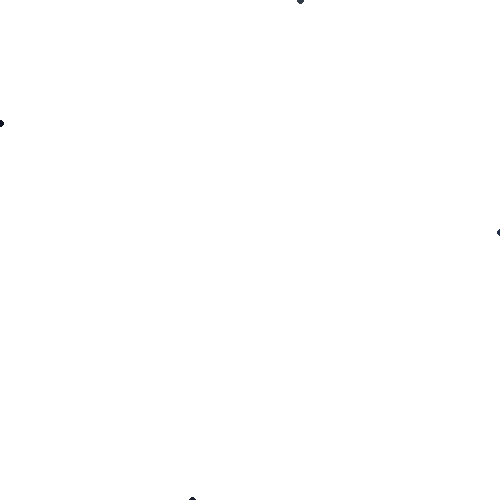

In [10]:
# Step 7. Apply perspective correction and try again

import numpy as np
from quadrilateral_fitter import QuadrilateralFitter

def apply_perspective_correction(x_coords, y_coords):
    # Combine x and y coordinates into a list of points
    points = np.array(list(zip(x_coords, y_coords)))
    
    # Fit the quadrilateral
    fitter = QuadrilateralFitter(polygon=points)
    fitted_quadrilateral = fitter.fit()
    
    # Extract x and y coordinates from fitted quadrilateral
    x_fitted = [point[0] for point in fitted_quadrilateral]
    y_fitted = [point[1] for point in fitted_quadrilateral]
    
    return x_fitted, y_fitted

x_transformed, y_transformed = apply_perspective_correction(x_coordinates, y_coordinates)

# Call the function to create the GIF
create_color_animation(relevant_tvs, x_transformed, y_transformed, num_frames=10, output_filename = 'perspective_fixed_animation.gif')

# Display the GIF
DisplayImage(filename='perspective_fixed_animation.gif')

In [11]:
import numpy as np

# Function to create test coordinates
def create_test_coordinates():
    # Define points that are more spread along the y-axis
    x_coords = np.array([1, 2, 3, 4])
    y_coords = np.array([10, 20, 30, 40])
    
    # Combine into points and rotate 45 degrees
    points = np.column_stack((x_coords, y_coords))
    angle = np.radians(45)
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], 
                                [np.sin(angle), np.cos(angle)]])
    
    # Apply rotation
    rotated_points = points @ rotation_matrix.T
    
    # Separate into x and y coordinates again
    x_rotated = rotated_points[:, 0]
    y_rotated = rotated_points[:, 1]
    
    return x_rotated, y_rotated

# Test the perspective correction function
def test_perspective_correction():
    x_test, y_test = create_test_coordinates()
    x_corrected, y_corrected = apply_perspective_correction(x_test, y_test)
    
    print("Original x:", x_test)
    print("Original y:", y_test)
    print("Corrected x:", x_corrected)
    print("Corrected y:", y_corrected)

# Run the test
test_perspective_correction()


AssertionError: No quadrilateral was found. This should never happen.